In [ ]:
# Required packages
!pip install torch-geometric
!pip install pytorch-lightning
!pip install h5py
!pip install matplotlib
!pip install tbparse

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import numpy as np
import h5py
import pytorch_lightning as pl
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/LuttingerWard_from_ML/code

In [2]:
import load_data as ld
import models

config = {}
config["PATH_TRAIN"] = "../data/batch1.hdf5"
data_set_conv = ld.Dataset_baseline_conv(config)

config["MODEL_NAME"] = "auto_encoder_conv"
config["in_dim"] = data_set_conv.data_in.shape[1]
config["batch_size"] = 1
config["learning_rate"] = 1e-4
config["weight_decay"] = 0
config["embedding_dim"] = 128 #int(config["in_dim"]/2)
config["hidden1_dim"] = int(config["embedding_dim"]/2)
config["hidden2_dim"] = int(config["embedding_dim"]/4)
config["encoder_dim"] = int(config["embedding_dim"]/8)
PATH = "../saves/save_auto_encoder_conv_2023-12-18/128xCPU/checkpoints/epoch=19-step=64000.ckpt"
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
model_conv = models.model_wraper_ae(config)
model_conv.load_state_dict(checkpoint['state_dict'])

################
config = {}
config["PATH_TRAIN"] = "../data/batch1.hdf5"
data_set = ld.Dataset_baseline(config)

config["MODEL_NAME"] = "auto_encoder"
config["in_dim"] = data_set.data_in.shape[1]
config["batch_size"] = 1
config["learning_rate"] = 1e-4
config["weight_decay"] = 0
config["embedding_dim"] = 128 #int(config["in_dim"]/2)
config["hidden1_dim"] = int(config["embedding_dim"]/2)
config["hidden2_dim"] = int(config["embedding_dim"]/4)
config["encoder_dim"] = int(config["embedding_dim"]/8)
PATH = "../saves/save_auto_encoder_2023-12-17/128xCPU/checkpoints/epoch=19-step=64000.ckpt"
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
model = models.model_wraper_ae(config)
model.load_state_dict(checkpoint['state_dict'])

#################
config = {}
config["PATH_TRAIN"] = "../data/batch1.hdf5"
data_set_graph = ld.Dataloader_graph(config)

config["MODEL_NAME"] = "GreenGNN"
config["batch_size"] = 1
config["learning_rate"] = 1e-4
config["weight_decay"] = 0
PATH = "../saves/save_GreenGNN_2023-12-17/8xA40/checkpoints/epoch=19-step=400000.ckpt"
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
model_graph = models.model_wraper_gnn(config)
model_graph.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### Predictions
Left figure shows target and predictions of all three models while middle and right figures show the real and imaginary part of the (identical) input.

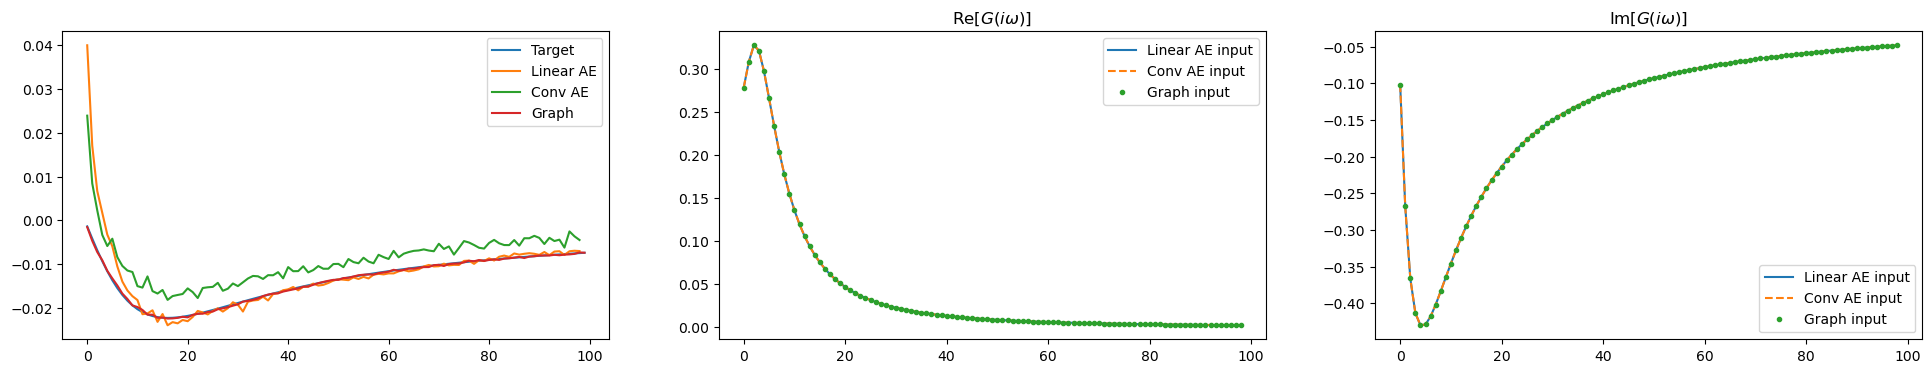

In [3]:
random_sample = int(np.random.rand()*len(data_set))

in_sample = data_set[random_sample][0]
in_sample_conv = data_set_conv[random_sample][0]
in_sample_graph = data_set_graph[random_sample]
in_sample_graph_idx = {}
in_sample_graph_idx["edge_index"] = in_sample_graph["edge_index"][None]
in_sample_graph_idx["node_feature"] = in_sample_graph["node_feature"][None]
in_sample_graph_idx["vectors"] = in_sample_graph["vectors"][None]
target_conv = data_set_conv[random_sample][1]
target = data_set[random_sample][1]
target_graph = data_set_graph[random_sample]["target"]
prediction = model.model(in_sample)
prediction_conv = model_conv.model(in_sample_conv[None,:,:])
prediction_graph = model_graph.model(in_sample_graph_idx)

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    fig,ax = plt.subplots(1,3, figsize=(24,4))
    ax[0].plot(target_graph[:].cpu(), label="Target")
    ax[0].plot(prediction[100:199].detach().numpy(), label="Linear AE")
    ax[0].plot(prediction_conv[0,100:199].detach().numpy(), label="Conv AE")
    ax[0].plot(prediction_graph[:].detach().numpy(), label="Graph")
    ax[0].legend()
    ax[1].plot(in_sample[0:99], label='Linear AE input')
    ax[1].plot(in_sample_conv[0,0:99], '--', label='Conv AE input')
    ax[1].plot(in_sample_graph_idx["node_feature"][0,0,100:199], '.', label='Graph input')
    ax[1].legend()
    ax[1].set_title('Re$[G(i\\omega)]$')
    ax[2].plot(in_sample[100:199], label='Linear AE input')
    ax[2].plot(in_sample_conv[1,0:99], '--', label='Conv AE input')
    ax[2].plot(in_sample_graph_idx["node_feature"][0,0,200:299], '.', label='Graph input')
    ax[2].legend()
    ax[2].set_title('Im$[G(i\\omega)]$')


### LOSS
Loss comparison during training and in validation. The loss of both  autoencoders (orange, blue) for the last 100 training steps remains clearly above the training loss of the graph network, which drops below the AE loss within the first few iterations (green).

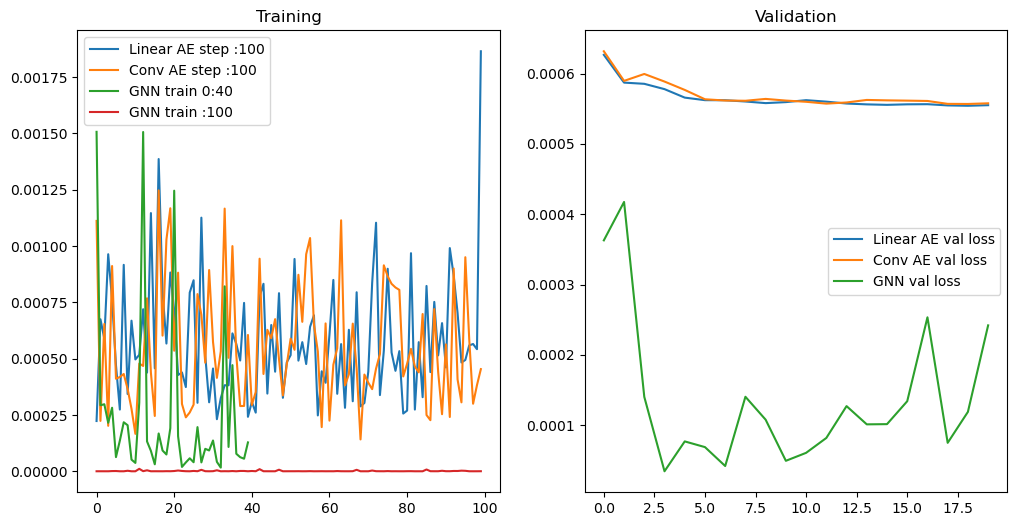

In [22]:
from tbparse import SummaryReader
log_dir = "../saves/save_GreenGNN_2023-12-17/8xA40/events.out.tfevents.1702853627.n3066-019.4045655.0"
reader = SummaryReader(log_dir)
df = reader.scalars
train_loss_gnn = df[df['tag'] == 'train_loss'].value
val_loss_gnn = df[df['tag'] == 'val_loss'].value
log_dir = "../saves/save_auto_encoder_2023-12-17/128xCPU/events.out.tfevents.1702849807.l53.vsc.xcat.1616104.0"
reader = SummaryReader(log_dir)
df = reader.scalars
train_loss_ae = df[df['tag'] == 'train_loss'].value
val_loss_ae = df[df['tag'] == 'val_loss'].value
log_dir = "../saves/save_auto_encoder_conv_2023-12-18/128xCPU/events.out.tfevents.1702890026.l51.vsc.xcat.146919.0"
reader = SummaryReader(log_dir)
df = reader.scalars
train_loss_ae_conv = df[df['tag'] == 'train_loss'].value
val_loss_ae_conv = df[df['tag'] == 'val_loss'].value


(fig,ax) = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(np.array(train_loss_ae[-100:]), label="Linear AE step :100")
ax[0].plot(np.array(train_loss_ae_conv[-100:]), label="Conv AE step :100")
ax[0].plot(np.array(train_loss_gnn[:40]), label="GNN train 0:40")
ax[0].plot(np.array(train_loss_gnn[-100:]), label="GNN train :100")
ax[0].legend()
ax[0].set_title("Training")
ax[1].plot(np.array(val_loss_ae), label="Linear AE val loss")
ax[1].plot(np.array(val_loss_ae_conv), label="Conv AE val loss")
ax[1].plot(np.array(val_loss_gnn), label="GNN val loss")
ax[1].legend()
ax[1].set_title("Validation");